In [ ]:
# Import the libraries

import os
import zipfile
import numpy as np
import pandas as pd
import random
import cv2
import shutil
from google.colab import files
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.gridspec as gridspec
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import seaborn as sns
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fatmaturan","key":"4a96e8dfa061023931a2558a8631308a"}'}

In [ ]:
# Let's create a folder
os.makedirs("/root/.kaggle", exist_ok=True)

# Let's move the file
shutil.move("kaggle.json", "/root/.kaggle/")

# Let's set permissions (for security)
os.chmod("/root/.kaggle/kaggle.json", 600)

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 97% 786M/812M [00:02<00:00, 266MB/s]
100% 812M/812M [00:03<00:00, 281MB/s]


In [ ]:
!unzip /content/dogs-vs-cats.zip -d /content/dogs-vs-cats # Let's extract the zip file.

Archive:  /content/dogs-vs-cats.zip
  inflating: /content/dogs-vs-cats/sampleSubmission.csv  
  inflating: /content/dogs-vs-cats/test1.zip  
  inflating: /content/dogs-vs-cats/train.zip  


In [ ]:
# Extract compressed file

path = "/content/dogs-vs-cats"
for zip_file in os.listdir(path)[:3]:
    if zip_file.endswith(".zip"):
      zipfile.ZipFile(f"{path}/{zip_file}", 'r').extractall(".")
      print(f"{path}/{zip_file}")
      print(f"{zip_file} unzipped")
    else:
      print(f"{zip_file} didn't extract.")

sampleSubmission.csv alınamadı
/content/dogs-vs-cats/train.zip
train.zip unzipped
/content/dogs-vs-cats/test1.zip
test1.zip unzipped


In [ ]:
# Let's check what files are in the Colab directory

os.listdir('/content/')

['.config',
 'dogs-vs-cats',
 'train',
 'dogs-vs-cats.zip',
 'test1',
 'sample_data']

In [ ]:
# Let's check the image files.

train_images = os.listdir("/content/train")
test_images = os.listdir("/content/test1")

print(f"Total Number of Training Images: {len(train_images)}")
print(f"Total Number of Test Images: {len(test_images)}")

Total Number of Training Images: 25000
Total Number of Test Images: 12500


# **Data Preprocessing**

● Load and visualize the dataset.

● Analyze the size, color channels, and distributions of the images.

● Perform preprocessing steps on the images (e.g., resize, normalize).

In [ ]:
Categories = []

for image_name in train_images:
    class_name = image_name.split('.')[0]
    Categories.append(0 if class_name=="cat" else 1)

df = pd.DataFrame({"train_images": train_images, "Categories": Categories})

In [ ]:
df.head()

train_images  Categories
0   cat.285.jpg           0
1  dog.1034.jpg           1
2  dog.3538.jpg           1
3  dog.9574.jpg           1
4  dog.1714.jpg           1

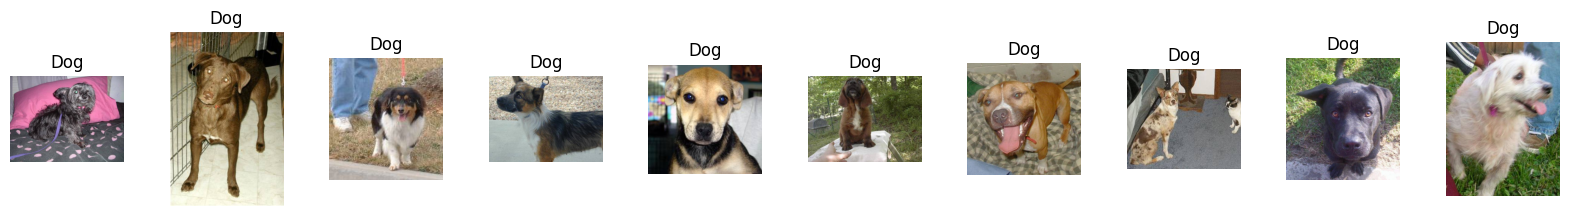

In [ ]:
plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(1, 10, wspace=0.4)

for i in range(10):
    ax = plt.subplot(gs[i])
    filename = 'train/' + 'dog.' + str(i) + '.jpg'
    image = imread(filename)
    ax.imshow(image)
    ax.set_title('Dog', fontsize=12)
    ax.axis('off')

plt.show()

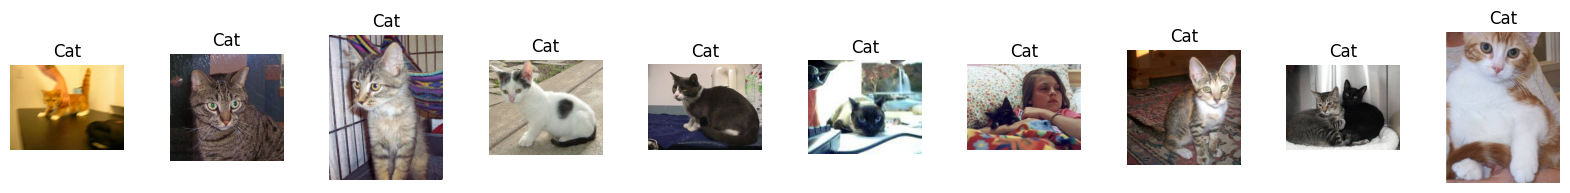

In [ ]:
plt.figure(figsize=(20, 20))
gs = gridspec.GridSpec(1, 10, wspace=0.4)

for i in range(10):
    ax = plt.subplot(gs[i])
    filename = 'train/' + 'cat.' + str(i) + '.jpg'
    image = imread(filename)
    ax.imshow(image)
    ax.set_title('Cat', fontsize=12)
    ax.axis('off')

plt.show()

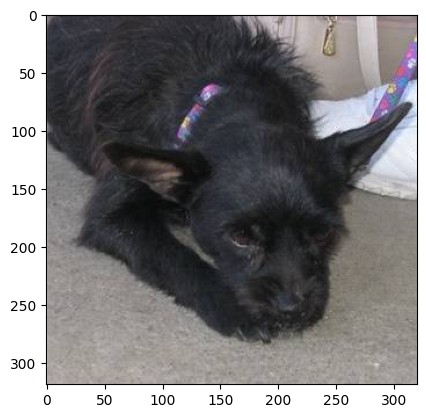

In [ ]:
# See sample images

sample = random.choice(train_images)
image = load_img("/content/train/"+sample)
plt.imshow(image)

In [ ]:
#Show dimensions of images

shapes = []

for image in df["train_images"]:
    path = os.path.join("/content/train",image)
    image_array = plt.imread(path)
    shapes.append(image_array.shape)

print(pd.Series(shapes).value_counts())

index = np.argmin(shapes)
print(f"\nThe Minimum Dimension is ==> {shapes[index]}\n")

(374, 500, 3)    2955
(375, 499, 3)    2912
(499, 375, 3)     261
(333, 499, 3)     229
(500, 374, 3)     227
                 ... 
(125, 192, 3)       1
(231, 224, 3)       1
(385, 278, 3)       1
(491, 367, 3)       1
(400, 337, 3)       1
Name: count, Length: 8513, dtype: int64

The Minimum Dimension is ==> (278, 377, 3)



In [ ]:
# Number of color channels 3 -> RGB

if len(image_array.shape) == 3:
    print("Number of color channels:", image_array.shape[2])  # 3 (BGR), 1 (Grayscale)
else:
    print("Single channel (Grayscale) image")

Renk Kanalı Sayısı: 3


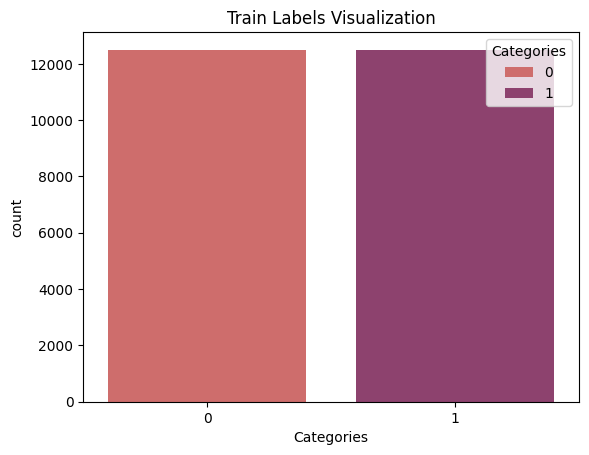

In [ ]:
plt.title('Train Labels Visualization');
sns.countplot(x=df["Categories"],palette='flare',hue = df["Categories"]);
plt.show();

In [ ]:
df.describe()

Categories
count  25000.00000
mean       0.50000
std        0.50001
min        0.00000
25%        0.00000
50%        0.50000
75%        1.00000
max        1.00000

In [ ]:
df.Categories.value_counts()

Categories
0    12500
1    12500
Name: count, dtype: int64

In [ ]:
# Read image

image = cv2.imread("/content/train/dog.3538.jpg")  # Add image path here
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV reads in BGR format, we convert it to RGB.

In [ ]:
# Separate color channels

R, G, B = cv2.split(image)

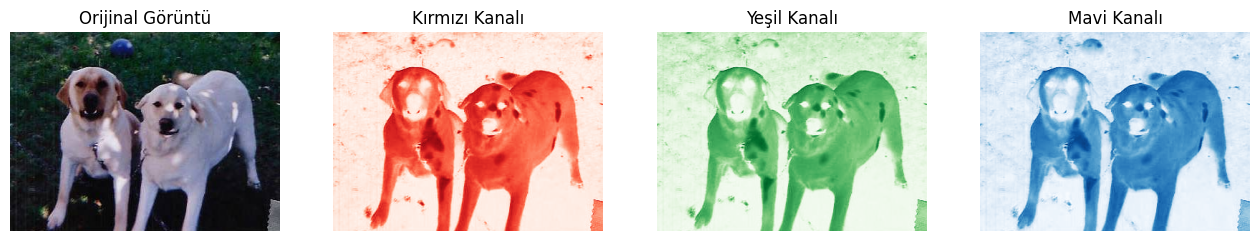

In [ ]:
# Visualizing color channels
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(image)
axes[0].set_title("Original view")
axes[0].axis("off")

axes[1].imshow(R, cmap="Reds")
axes[1].set_title("Red Channel")
axes[1].axis("off")

axes[2].imshow(G, cmap="Greens")
axes[2].set_title("Green Channel")
axes[2].axis("off")

axes[3].imshow(B, cmap="Blues")
axes[3].set_title("Blue Channel")
axes[3].axis("off")

plt.show()

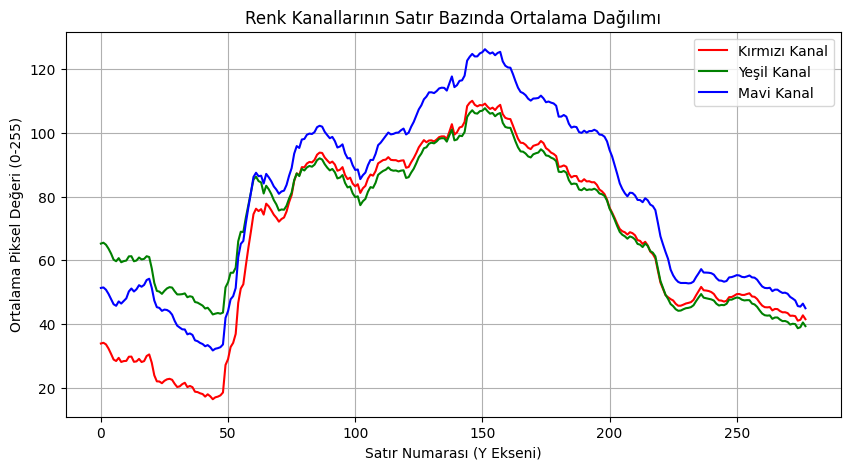

In [ ]:
# Calculate the average color values in each row

red_mean = np.mean(R, axis=1)  # Red Channel
green_mean = np.mean(G, axis=1)  # Green Channel
blue_mean = np.mean(B, axis=1)  # Blue Channel

# Line plot drawing

plt.figure(figsize=(10, 5))
plt.plot(red_mean, color="red", label="Red Channel")
plt.plot(green_mean, color="green", label="Green Channel")
plt.plot(blue_mean, color="blue", label="Blue Channel")

# Edit the chart

plt.title("Average Distribution of Color Channels by Row")
plt.xlabel("Row Number (Y Axis)")
plt.ylabel("Average Pixel Value (0-255)")
plt.legend()
plt.grid(True)

# Show chart

plt.show()

Perform preprocessing steps on images (e.g. resizing, normalization).

In [ ]:
df.head()

train_images  Categories
0   dog.5981.jpg           1
1  cat.11788.jpg           0
2   cat.6165.jpg           0
3   cat.5470.jpg           0
4   cat.8328.jpg           0

In [ ]:
# Train-Test split (80% Train, 20% Test)

X_train, X_test = train_test_split(df, test_size=0.20, random_state=42)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [ ]:
# Train-validation split (80% Train, 20% validation)

train_df, validate_df = train_test_split(X_train, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [ ]:
# Define data augmentation process

train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize images
    rotation_range=40,        # Rotate images 0-40 degrees
    width_shift_range=0.2,    # Horizontal scrolling
    height_shift_range=0.2,   # Vertical scrolling
    shear_range=0.2,          # Cutting
    zoom_range=0.2,           # Zoom
    horizontal_flip=True,     # horizontal flip
    fill_mode='nearest'       # Fill in the blank fields
)

In [ ]:
train_df['Categories'] = train_df ['Categories'].astype(str)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/train",
    x_col='train_images',
    y_col='Categories',
    target_size=(256,256),
    class_mode='binary',
    batch_size=32
)

Found 16000 validated image filenames belonging to 2 classes.


In [ ]:
validate_df['Categories'] = validate_df ['Categories'].astype(str)

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/train",
   x_col='train_images',
    y_col='Categories',
    target_size=(256,256),
    class_mode='binary',
    batch_size=32
)


Found 4000 validated image filenames belonging to 2 classes.


In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/train",
    x_col='train_images',
    y_col='Categories',
    target_size=(256,256)
)

Found 1 validated image filenames belonging to 1 classes.


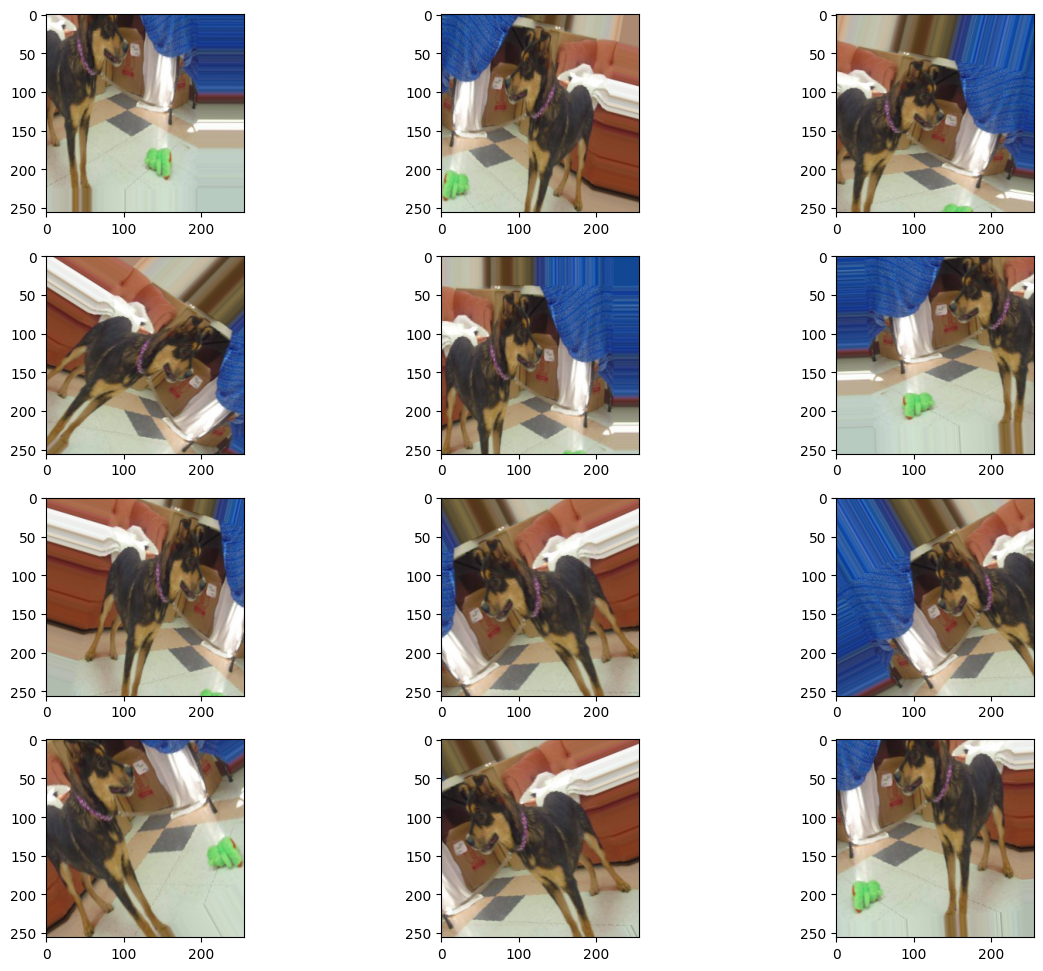

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 12):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# **2. Model Selection and Training:**

● Review and select deep learning models (e.g., convolutional neural networks - CNNs).

● Use the training and validation datasets to train your chosen model. If necessary, adjust the model to avoid overfitting (e.g., add dropout layers).

● Train the model on the validation set, monitoring its accuracy, and determine appropriate hyperparameters.


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2,2),  # Reduce size with MaxPooling

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),  # Reduce size with MaxPooling

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),  # Reduce size with MaxPooling

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),  # Set correct input size
    tf.keras.layers.Dropout(0.5), # Dropout to prevent overfitting
    tf.keras.layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      58,982,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,076,673 (225.36 MB)

 Trainable params: 59,076,673 (225.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=32

In [ ]:
epochs=10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    batch_size= batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 270s 522ms/step - accuracy: 0.5268 - loss: 0.7933 - val_accuracy: 0.5620 - val_loss: 0.6796
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 314s 519ms/step - accuracy: 0.6064 - loss: 0.6605 - val_accuracy: 0.6865 - val_loss: 0.6114
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 258s 517ms/step - accuracy: 0.6447 - loss: 0.6330 - val_accuracy: 0.7185 - val_loss: 0.5636
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 262s 524ms/step - accuracy: 0.6894 - loss: 0.5965 - val_accuracy: 0.7057 - val_loss: 0.5887
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 256s 512ms/step - accuracy: 0.7010 - loss: 0.5749 - val_accuracy: 0.7755 - val_loss: 0.4834
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 255s 510ms/step - accuracy: 0.7257 - loss: 0.5434 - val_accuracy: 0.7793 - val_loss: 0.4704
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 256s 511ms/step - accuracy: 0.7341 - loss: 0.5345 - val_accuracy: 0.7665 - val_loss: 0.5010
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 258s 517ms/step - accuracy: 0.7535 -

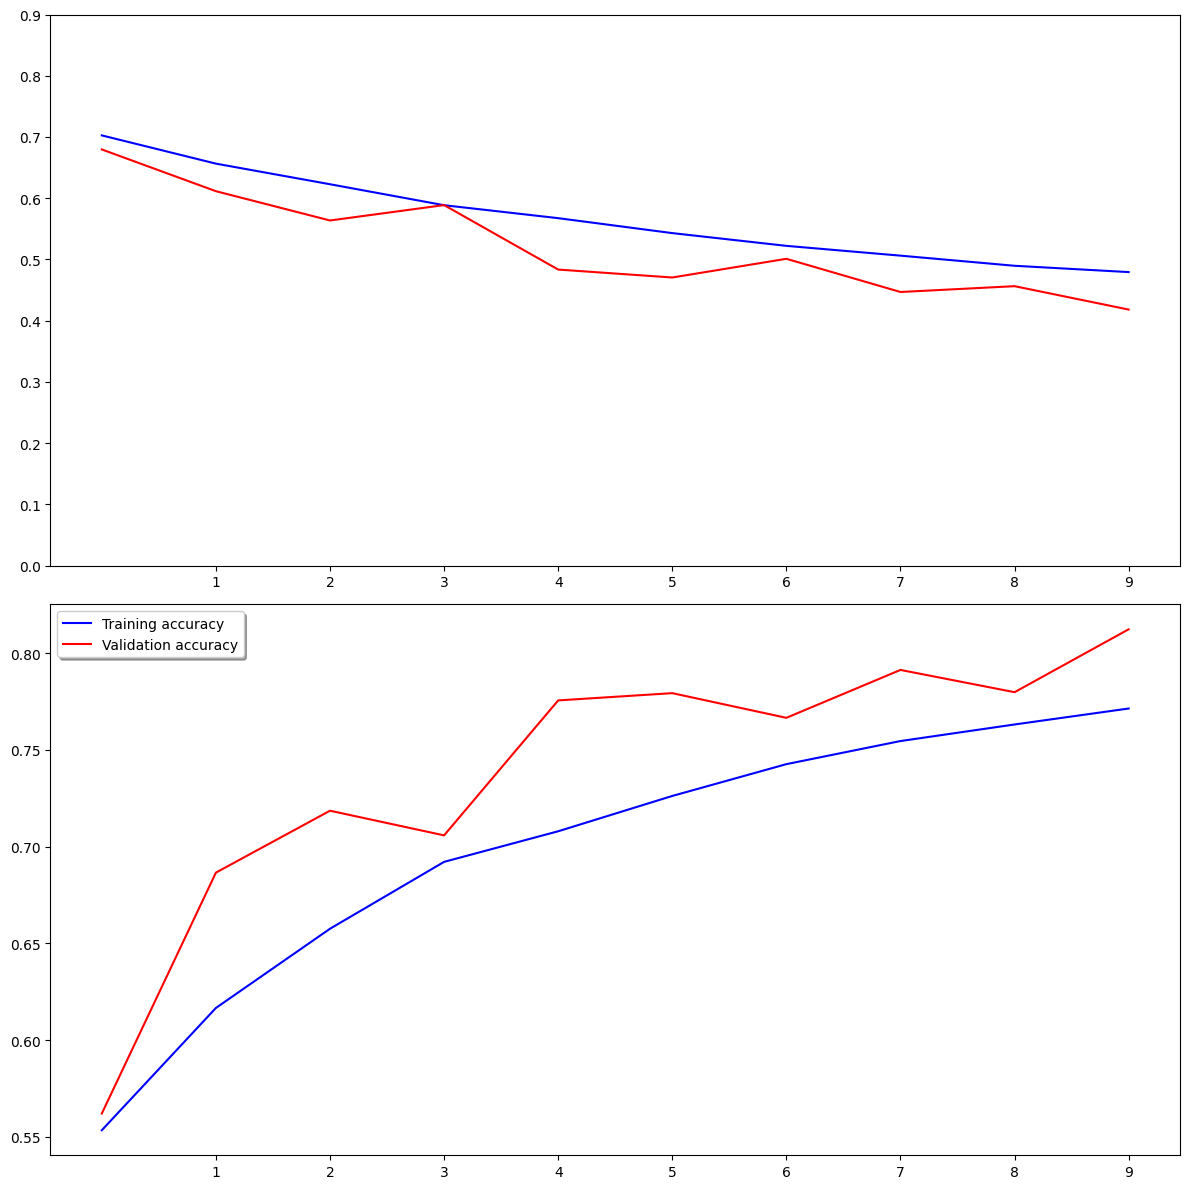

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
# Configure the learning rate reduction callback

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)

In [ ]:
epochs=10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=[learning_rate_reduction,early_stoping]
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 263s 525ms/step - accuracy: 0.7765 - loss: 0.4741 - val_accuracy: 0.7990 - val_loss: 0.4259 - learning_rate: 0.0010
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 260s 520ms/step - accuracy: 0.7822 - loss: 0.4633 - val_accuracy: 0.8117 - val_loss: 0.4144 - learning_rate: 0.0010
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 262s 519ms/step - accuracy: 0.7906 - loss: 0.4504 - val_accuracy: 0.8350 - val_loss: 0.3873 - learning_rate: 0.0010
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 259s 517ms/step - accuracy: 0.7932 - loss: 0.4467 - val_accuracy: 0.8313 - val_loss: 0.3886 - learning_rate: 0.0010
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.8071 - loss: 0.4212
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
500/500 ━━━━━━━━━━━━━━━━━━━━ 257s 513ms/step - accuracy: 0.8071 - loss: 0.4212 - val_accuracy: 0.7952 - val_loss: 0.4389 - learning_rate: 0.0010
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 258s 516ms/step - accuracy:

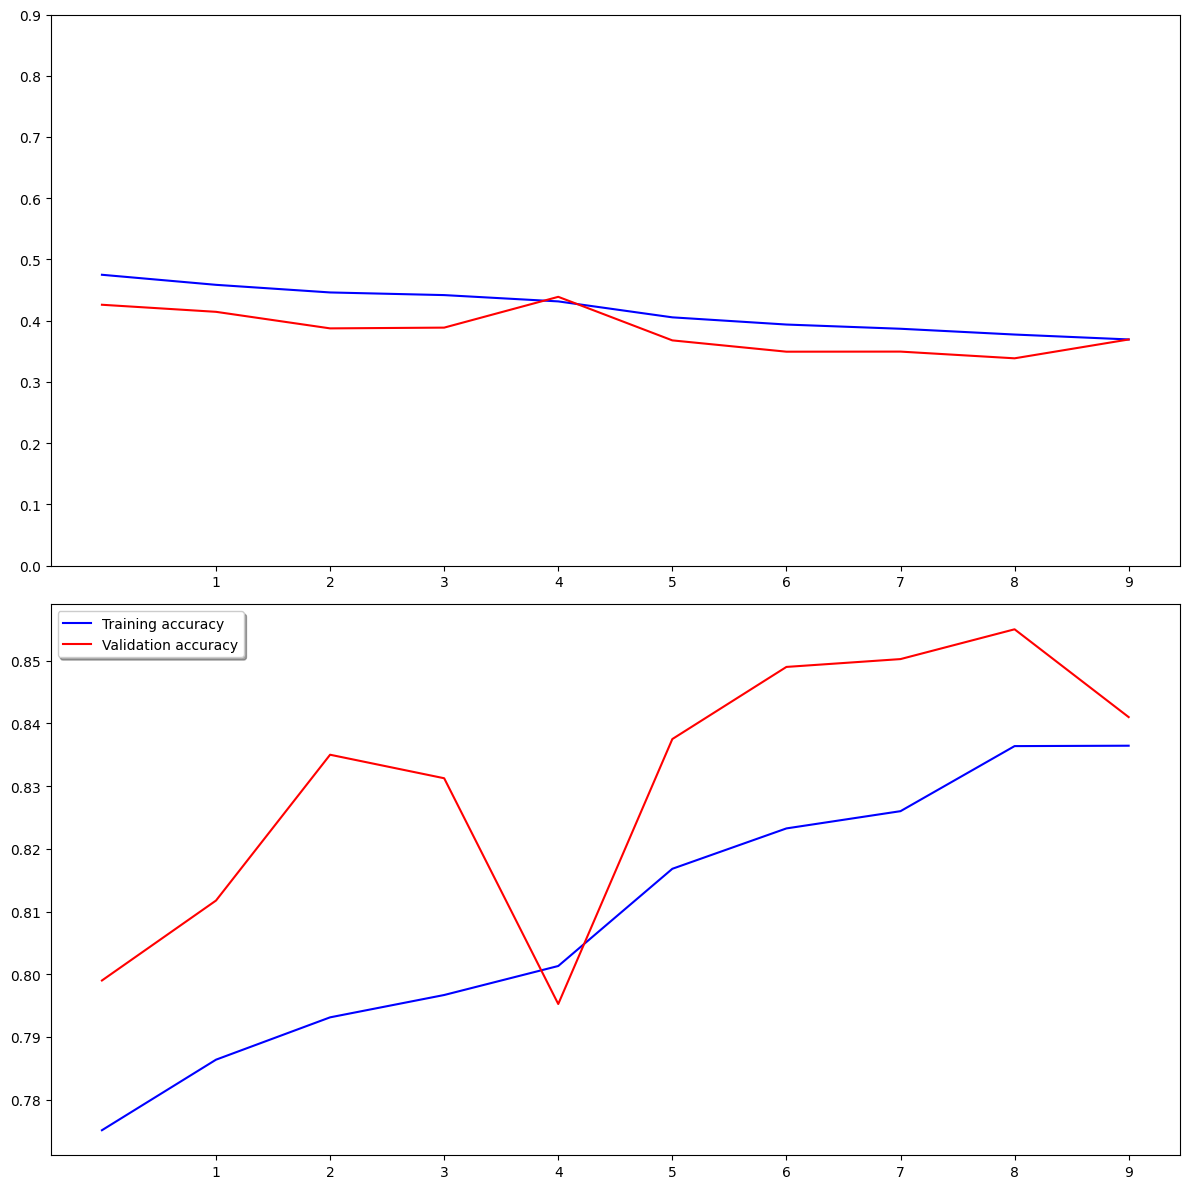

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluvate for train generator

loss,acc = model.evaluate(train_generator,batch_size = batch_size, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator

loss,acc = model.evaluate(validation_generator,batch_size = batch_size, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 83.97499918937683
The Loss of the model for training data is: 0.3688875138759613
The accuracy of the model for validation data is: 85.50000190734863
The Loss of the model for validation data is: 0.33844953775405884


# **Model Evaluation**

● After training is complete, evaluate the model’s performance on the test set.

● Analyze the model’s performance using metrics such as classification accuracy, confusion matrix, precision, and recall.

● Examine errors by visualizing examples where the model misclassified.

In [ ]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)

In [ ]:
X_test['Categories'] = X_test ['Categories'].astype(str)

In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    X_test,
    "/content/train",
    x_col='train_images',
    y_col='Categories',
    class_mode="categorical",
    target_size=(256, 256),
    batch_size=32,
    shuffle=False
)

Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
# Get Predictions from the Model

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)  # Get the class with the highest probability

print("Tahmin Edilen Sınıflar:", predicted_classes)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step
Tahmin Edilen Sınıflar: [0 0 0 ... 0 0 0]


157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step


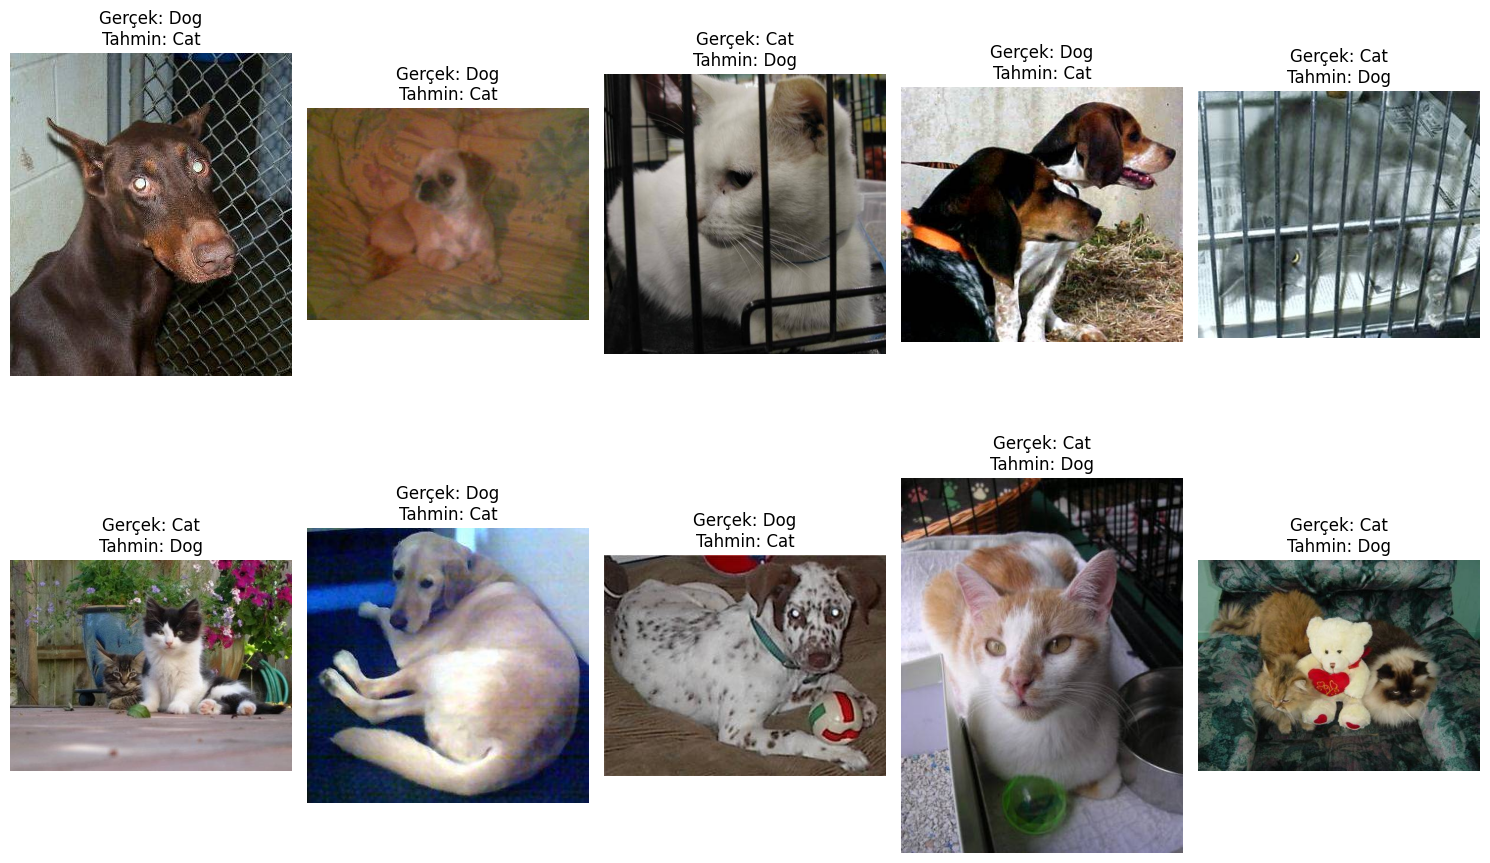

In [ ]:
# Make predictions on the test set

predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = (predictions > 0.5).astype("int32").flatten()

# Get real tags

true_classes = test_generator.classes

# Find misclassified samples

incorrect_indices = np.where(predicted_classes != true_classes)[0]

# Visualize misclassified examples

plt.figure(figsize=(15, 10))
for i, idx in enumerate(incorrect_indices[:10]):  # Show top 10 misclassified examples
    plt.subplot(2, 5, i + 1)
    img_path = test_generator.filepaths[idx]
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(f"Gerçek: {'Dog' if true_classes[idx] == 1 else 'Cat'}\nTahmin: {'Dog' if predicted_classes[idx] == 1 else 'Cat'}")
    plt.axis("off")

plt.tight_layout()
plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step


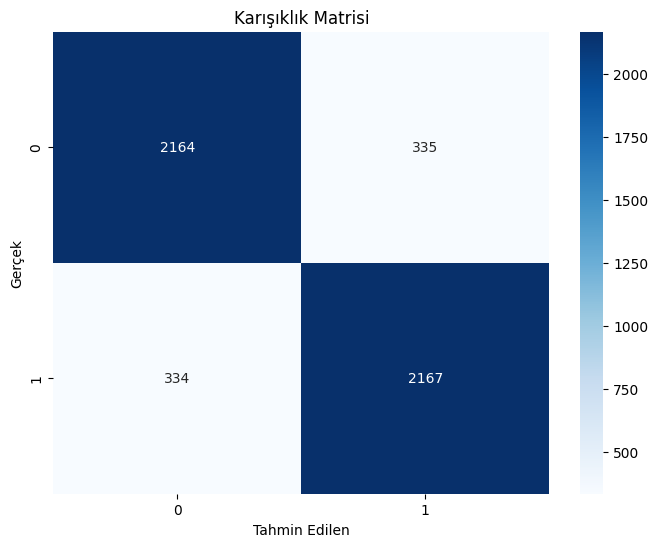

Sınıflandırma Raporu:

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2499
           1       0.87      0.87      0.87      2501

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



In [ ]:
# Let's make a prediction on the validation set
Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.round(Y_pred).astype(int).reshape(-1)  # Rounding to classify as 0 or 1

# Let's get the real tags
y_true = test_generator.classes

# Let's make a confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Karışıklık Matrisi')
plt.show()

# Let's print the classification report (accuracy, precision, recall and F1 score
print("Sınıflandırma Raporu:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))